# Exploration des données

In [88]:
# Importations

import pickle
import pandas as pd
import numpy as np
import haversine as hs # Un module qui permet de calculer la distance entre deux points en fonction de leurs coordonnées GPS
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Découverte des datasets

Pour commencer, découvrons tous les datasets afin de nous familiariser avec leur contenu et de définir quelles données pourront potentiellement nous être utiles.

In [2]:
customers_df = pd.read_csv("data/olist_customers_dataset.csv")
print(customers_df.info())
print(customers_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code

On remarque que ce dataset pourrait nous être utile, dans la mesure où il contient des informations sur les clients.

In [3]:
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")
print(geolocation_df.info())
print(geolocation_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.64

Même si l'intérêt de ce dataset semble plus limité pour établir une segmentation des clients, on pourrait tout à fait imaginer que la géolocalisation des clients soit un facteur qui serait à l'origine de différences régionales dans le comportement des clients. Par exemple, on pourrait tout à fait imaginer un cas où les habitants d'une région commanderaient plus ou moins certains produits pour des raisons culturelles ou religieuses, par exemple. Dans ce cas, la géolocalisation pourrait être une information précieuse : c'est pourquoi nous allons  aussi utiliser ce dataset dans notre analyse.

In [4]:
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv")
print(order_items_df.info())
print(order_items_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id    

Les produits commandés ainsi que leur prix sont des informations cruciales pour comprendre les clients : nous allons donc utiliser ce dataset dans nos analyses.

In [5]:
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")
print(order_payments_df.info())
print(order_payments_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None
                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  p

Ce dataset pourrait nous apprendre des choses sur les habitudes de paiement des clients (méthode de paiement, paiement en une ou plusieurs fois...). Gardons-le pour notre analyse.

In [6]:
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv")
print(order_reviews_df.info())
print(order_reviews_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511

Ici, le dataset donne des informations sur les éventuels commentaires laissés par des clients. L'intérêt pourrait être de segmenter les clients en prenant en compte le fait qu'ils laissent des commentaires ou non, voire de convertir le texte des messages en vecteurs pour les utiliser dans notre modèle de segmentation. Il paraît donc judicieux de garder ces données.

In [7]:
orders_df = pd.read_csv("data/olist_orders_dataset.csv")
print(orders_df.info())
print(orders_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  4

Ce dataset nous permettra de faire des fusions entre les différents datasets qui nous intéressent, via les colonnes order_id et customer_id. Les données décrivant les délais de livraison nous permettront aussi d'étudier la temporalité des commandes et pourront peut-être être utiles pour définir plusieurs catégories de clients (on pourrait tout à fait envisager que certains clients veulent être livrés rapidement, par exemple, ce qui aurait une influence sur la stratégie marketing à adopter à leur égard)

In [8]:
products_df = pd.read_csv("data/olist_products_dataset.csv")
print(products_df.info())
print(products_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None
                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b

Ici, c'est surtout la colonne product_category_name qui va nous intéresser. En effet, tandis que différents clients achètent différents types de produits, on peine à comprendre comment les dimensions ou le poids des produits pourraient avoir une influence sur le comportement des clients !

In [9]:
sellers_df = pd.read_csv("data/olist_sellers_dataset.csv")
print(sellers_df.info())
print(sellers_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
                          seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3  

Ici, la colonne seller_zip_code_prefix pourrait nous être utile. De nos jours, de plus en plus de clients cherchent à consommer local. Il s'ensuit que connaître la localisation du vendeur et celle de l'acheteur pourrait peut-être nous permettre de calculer la distance, ce qui aurait son importance. 

In [10]:
product_category_name_translation_df = pd.read_csv("data/product_category_name_translation.csv")
print(product_category_name_translation_df.info())
print(product_category_name_translation_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None
    product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor


Cette table nous servira à remplacer les noms des catégories en portugais par ceux en anglais. Dans la mesure où personne ne parle portugais dans l'équipe, cela semble être un bon moyen de mieux comprendre les résultats du modèle.

## Création d'une dataframe unique

Dans cette partie, nous allons créer une unique dataframe qui contient toutes les informations qui peuvent potentiellement nous intéresser. De là, nous pourrons ensuite facilement créer d'autres colonnes qui nous intéressent à partir d'autres données (e.g. créer une colonne "distance moyenne entre le client et les vendeurs") et réaliser des analyses pour mieux comprendre les relations entre les données. La dataframe ainsi obtenue sera sauvegardée avec Pickle afin de ne pas avoir à exécuter tout le code du notebook à chaque fois que l'on souhaite accéder à la dataframe.

Cette dataframe unique devra référencer les clients (une ligne = un client). Nous allons donc prendre comme base la dataframe customers_df. Dans un premier temps, fusionnons customers_df et geolocation_df.

In [11]:
unique_df = customers_df
# Dans geolocation_df, le même code postal peut avoir plusieurs coordonnées. On commence
# donc par supprimer tous les doublons en se basant sur les codes zip pour que chaque
# code corresponde à une seule paire de coordonnées.
geolocation_df.drop_duplicates(subset=["geolocation_zip_code_prefix"], inplace=True)
unique_df = unique_df.merge(geolocation_df, how="left", left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")
print(unique_df.info())
print(unique_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   geolocation_zip_code_prefix  99163 non-null  float64
 6   geolocation_lat              99163 non-null  float64
 7   geolocation_lng              99163 non-null  float64
 8   geolocation_city             99163 non-null  object 
 9   geolocation_state            99163 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 8.3+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b9

On pensera aussi à supprimer les colonnes en doublon et celles qui ne nous intéressent pas :

In [12]:
unique_df.drop(columns=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], inplace=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  int64  
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
 5   geolocation_lat           99163 non-null  float64
 6   geolocation_lng           99163 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.1+ MB
None


Au passage, on renomme les colonnes pour simplifier un peu :

In [13]:
names_mapping = {
                "customer_id": "id",
                "customer_unique_id": "unique_id",
                "customer_zip_code_prefix": "zip",
                "customer_city": "city",
                "customer_state": "state",
                "geolocation_lat": "lat",
                "geolocation_lng": "lng"
                }
                 
unique_df.rename(columns=names_mapping, inplace=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         99441 non-null  object 
 1   unique_id  99441 non-null  object 
 2   zip        99441 non-null  int64  
 3   city       99441 non-null  object 
 4   state      99441 non-null  object 
 5   lat        99163 non-null  float64
 6   lng        99163 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.1+ MB
None


Notre prochain objectif sera d'ajouter les colonnes suivantes à notre dataframe :
- "total_spent" : le montant total dépensé par le client, toutes commandes confondues
- "avg_spent" : le montant de commande moyen du client
- "avg_installments" : le nombre moyen de paiements par commande pour le client
- "avg_review" : la note moyenne donnée par le client après ses commandes
- "favorite_category" : la catégorie de produits la plus achetée par le client (on prendra le nom de la catégorie en anglais).
- "distance_to_seller" : la distance entre la ville où se trouve le vendeur et celle où se trouve le client.


Après réflexion, nous ne nous occuperons pas des données qui concernent les dates et délais de livraison pour l'instant afin de nous concentrer sur les colonnes qui paraissent les plus pertinentes pour segmenter les clients. Par ailleurs, les messages contenus dans les reviews ne seront pas utilisés, du moins dans un premier temps. Il faudrait pour cela les vectoriser, ce qui alourdirait considérablement notre futur modèle.

### Ajout de la colonne avg_review

On commence par ajouter une colonne contenant l'id du client à la dataframe order_reviews_df.

In [14]:
# Création d'une table intermediate_df qui reprend les données de order_reviews_df 
# et y ajoute une colonne qui contient l'id unique du client qui a passé la commande
intermediate_df = order_reviews_df.merge(orders_df, how="left", on="order_id")
intermediate_df = intermediate_df.drop(columns=["review_creation_date", 
                                                "review_answer_timestamp",
                                                "order_status",
                                                "order_purchase_timestamp",
                                                "order_approved_at",
                                                "order_delivered_carrier_date",
                                                "order_delivered_customer_date",
                                                "order_estimated_delivery_date"])
intermediate_df = intermediate_df.merge(customers_df, how="left", on="customer_id")
intermediate_df.drop(columns=["customer_zip_code_prefix",
                              "customer_city",
                              "customer_state"], inplace= True)

print(intermediate_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   order_id                99224 non-null  object
 2   review_score            99224 non-null  int64 
 3   review_comment_title    11568 non-null  object
 4   review_comment_message  40977 non-null  object
 5   customer_id             99224 non-null  object
 6   customer_unique_id      99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 6.1+ MB
None


Ensuite, on crée une colonne avg_review qui contient la note moyenne donnée par chaque client et on l'ajoute à notre dataframe unique_df :

In [15]:
reviews_df = intermediate_df.groupby(["customer_unique_id"]).mean(numeric_only=True)
reviews_df.rename(columns={"review_score": "avg_review"}, inplace=True)
unique_df = unique_df.merge(how="left", right=reviews_df, left_on="unique_id", right_on="customer_unique_id")
print(unique_df.info())
print(unique_df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          99441 non-null  object 
 1   unique_id   99441 non-null  object 
 2   zip         99441 non-null  int64  
 3   city        99441 non-null  object 
 4   state       99441 non-null  object 
 5   lat         99163 non-null  float64
 6   lng         99163 non-null  float64
 7   avg_review  98716 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.8+ MB
None
                                 id                         unique_id    zip  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0  14409   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   9790   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   1151   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   8775   
4  4f2d8ab171c8

### Ajout des colonnes total_spent et avg_spent

Pour récupérer ces informations, on commencera par créer une dataframe qui répertorie tous les articles vendus avec les id du client et de la commande, le prix de l'article et sa catégorie. On se basera sur la dataframe order_items_df.

In [16]:
sold_items_df = order_items_df.copy()
sold_items_df.drop(columns=["shipping_limit_date", "freight_value"], inplace=True)
sold_items_df = sold_items_df.merge(how="left", right=orders_df, on="order_id")
sold_items_df.drop(columns=["order_status", 
                            "order_purchase_timestamp",
                            "order_approved_at",
                            "order_delivered_carrier_date",
                            "order_delivered_customer_date",
                            "order_estimated_delivery_date"], inplace=True)
sold_items_df = sold_items_df.merge(how="left", right=customers_df, left_on="customer_id", right_on="customer_id")

print(sold_items_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_item_id             112650 non-null  int64  
 2   product_id                112650 non-null  object 
 3   seller_id                 112650 non-null  object 
 4   price                     112650 non-null  float64
 5   customer_id               112650 non-null  object 
 6   customer_unique_id        112650 non-null  object 
 7   customer_zip_code_prefix  112650 non-null  int64  
 8   customer_city             112650 non-null  object 
 9   customer_state            112650 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 9.5+ MB
None


On ajoute ensuite les colonnes qui nous intéressent (total_spent et avg_spent)

In [17]:
total_spent = sold_items_df.groupby(["customer_unique_id"]).sum(numeric_only=True)
by_order = sold_items_df.groupby(["order_id"]).sum(numeric_only = True)
by_order.rename(columns={"price": "avg_spent"}, inplace=True)
sold_items_df = sold_items_df.merge(how="left", right=by_order["avg_spent"], left_on="order_id", right_index=True)
avg_spent = sold_items_df.groupby(["customer_unique_id"]).mean(numeric_only=True)

On ajoute les deux colonnes nouvellement créées à notre dataframe unique_df :

In [18]:
total_spent.rename(columns={"price": "total_spent"}, inplace=True)
unique_df = unique_df.merge(how="left", right=total_spent["total_spent"], left_on="unique_id", right_index=True)
unique_df = unique_df.merge(how="left", right=avg_spent["avg_spent"], left_on="unique_id", right_index=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           99441 non-null  object 
 1   unique_id    99441 non-null  object 
 2   zip          99441 non-null  int64  
 3   city         99441 non-null  object 
 4   state        99441 non-null  object 
 5   lat          99163 non-null  float64
 6   lng          99163 non-null  float64
 7   avg_review   98716 non-null  float64
 8   total_spent  98756 non-null  float64
 9   avg_spent    98756 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 8.3+ MB
None


### Ajout des colonnes avg_installments, favorite_category et distance_to_seller

On commence par ajouter à notre dataframe sold_items_df les informations concernant les paiements, les catégories de produits et les vendeurs.

In [19]:
sold_items_df = sold_items_df.merge(how="left", right=products_df, on="product_id")
sold_items_df.drop(columns=["product_name_lenght",
                            "product_description_lenght",
                            "product_photos_qty",
                            "product_weight_g",
                            "product_length_cm",
                            "product_height_cm",
                            "product_width_cm"], inplace=True)

sold_items_df = sold_items_df.merge(how="left", right=sellers_df, on="seller_id")
sold_items_df = sold_items_df.merge(how="left", right=order_payments_df, on="order_id")
sold_items_df.drop(columns=["payment_sequential", "payment_type", "payment_value"], inplace=True)


print(sold_items_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  117604 non-null  object 
 1   order_item_id             117604 non-null  int64  
 2   product_id                117604 non-null  object 
 3   seller_id                 117604 non-null  object 
 4   price                     117604 non-null  float64
 5   customer_id               117604 non-null  object 
 6   customer_unique_id        117604 non-null  object 
 7   customer_zip_code_prefix  117604 non-null  int64  
 8   customer_city             117604 non-null  object 
 9   customer_state            117604 non-null  object 
 10  avg_spent                 117604 non-null  float64
 11  product_category_name     115906 non-null  object 
 12  seller_zip_code_prefix    117604 non-null  int64  
 13  seller_city               117604 non-null  o

À partir de cette dataframe, on va générer trois nouvelles dataframes qui contiennent respectivement la catégorie de produits préférée de chaque client, sa distance moyenne avec les vendeurs où il achète ses articles, et le nombre de paiements moyen qu'il réalise lors de ses achats. Dans la foulée, on ajoutera ces données à notre dataframe unique.

In [20]:
# Nombre de paiements moyen réalisés par achat, par client
avg_installments = sold_items_df.groupby(["customer_unique_id"]).mean(numeric_only=True)
avg_installments.rename(columns={"payment_installments": "avg_installments"}, inplace=True)
unique_df = unique_df.merge(how="left", right=avg_installments["avg_installments"], left_on="unique_id", right_index=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                99441 non-null  object 
 1   unique_id         99441 non-null  object 
 2   zip               99441 non-null  int64  
 3   city              99441 non-null  object 
 4   state             99441 non-null  object 
 5   lat               99163 non-null  float64
 6   lng               99163 non-null  float64
 7   avg_review        98716 non-null  float64
 8   total_spent       98756 non-null  float64
 9   avg_spent         98756 non-null  float64
 10  avg_installments  98755 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 9.1+ MB
None


Passons maintenant à la catégorie de produits préférée du client. Ici, on réalise que plusieurs problèmes se posent :
- Certains clients n'ont pas une unique catégorie de produits préférée (e.g. pour un client qui a commandé en tout deux articles de catégories différentes)
- Ces catégories de produits, actuellement en format texte, devront être converties en nombres pour être exploitables par un modèle de clustering. Une solution serait d'attribuer un index sous la forme d'un nombre entier à chaque catégorie. Cependant, **procéder de cette manière impliquerait une "proximité" mathématique entre certaines catégories**. Autrement dit, la catégorie d'index 5 serait considérée comme "proche" de la catégorie d'index 6, ce qui serait faux (la catégorie 5 pourrait ne rien avoir en commun avec la catégorie 6 mais être relativement similaire à la catégorie 32, par exemple). 

Pour ces raisons, on préférera dans un premier temps ne pas exploiter les données concernant la catégorie des produits. On pourra envisager de les exploiter plus tard, si le temps le permet et que des solutions adaptées sont trouvées pour résoudre les deux problèmes ci-dessus.

In [21]:
# Ajout de la colonne distance_to_seller
# Pour commencer, on code une fonction qui calcule la distance entre 
# deux points en fonction de leurs coordonnées GPS

def get_distance(lat1: float,
                long1: float,
                lat2: float,
                long2: float) -> float:
    """Renvoit la distance entre deux points (en km)"""
    
    return hs.haversine((lat1, long1), (lat2, long2))

# On ajoute quatre colonnes à sold_items_df : customer_lat, customer_long, 
# seller_lat et seller_long

sold_items_df = sold_items_df.merge(how="left", right=geolocation_df, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")
sold_items_df.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_long"}, inplace=True)
sold_items_df = sold_items_df.merge(how="left", right=geolocation_df, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix")
sold_items_df.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_long"}, inplace=True)

# On génère ensuite une nouvelle colonne distance_to_seller en se basant sur ces coordonnées, puis on l'ajoute à unique_df
sold_items_df["distance_to_seller"] = sold_items_df.apply(lambda row: get_distance(row["customer_lat"],
                                                         row["customer_long"],
                                                         row["seller_lat"],
                                                         row["seller_long"]), axis=1)

clients_and_distance = sold_items_df.groupby(["customer_unique_id"]).mean(numeric_only=True)

unique_df = unique_df.merge(how="left", right=clients_and_distance["distance_to_seller"], left_on="unique_id", right_index=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  99441 non-null  object 
 1   unique_id           99441 non-null  object 
 2   zip                 99441 non-null  int64  
 3   city                99441 non-null  object 
 4   state               99441 non-null  object 
 5   lat                 99163 non-null  float64
 6   lng                 99163 non-null  float64
 7   avg_review          98716 non-null  float64
 8   total_spent         98756 non-null  float64
 9   avg_spent           98756 non-null  float64
 10  avg_installments    98755 non-null  float64
 11  distance_to_seller  98276 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 9.9+ MB
None


Nous voilà maintenant avec un unique dataset prêt à l'emploi qui contient uniquement les colonnes qui nous intéressent :

In [22]:
print(unique_df.head())

                                 id                         unique_id    zip  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0  14409   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   9790   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   1151   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   8775   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066  13056   

                    city state        lat        lng  avg_review  total_spent  \
0                 franca    SP -20.509897 -47.397866         4.0       124.99   
1  sao bernardo do campo    SP -23.726853 -46.545746         5.0       289.00   
2              sao paulo    SP -23.527788 -46.660310         5.0       139.94   
3        mogi das cruzes    SP -23.496930 -46.185352         5.0       149.94   
4               campinas    SP -22.987222 -47.151073         5.0       230.00   

   avg_spent  avg_installments  

Pour finir, on constate que certaines colonnes contiennent quelques cases vides. Au vu de la faible quantité de données concernée, on préférera simplement supprimer toutes les lignes où il manque des valeurs :

In [23]:
unique_df.dropna(inplace=True)
unique_df.drop(columns=["id"], inplace=True)
print(unique_df.info())
pickle.dump(unique_df, open("clean_data.pkl", "wb"))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97567 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           97567 non-null  object 
 1   zip                 97567 non-null  int64  
 2   city                97567 non-null  object 
 3   state               97567 non-null  object 
 4   lat                 97567 non-null  float64
 5   lng                 97567 non-null  float64
 6   avg_review          97567 non-null  float64
 7   total_spent         97567 non-null  float64
 8   avg_spent           97567 non-null  float64
 9   avg_installments    97567 non-null  float64
 10  distance_to_seller  97567 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 8.9+ MB
None


## Visualisation des données et analyses statistiques

Maintenant que nous avons nettoyé nos données et obtenu une dataframe directement exploitable pour faire du clustering, nous pouvons analyser plus en profondeur les données afin de mieux les comprendre. Pour cela, nous allons réaliser des visualisations graphiques des données et effectuer des analyses statistiques pour étudier leur répartition.

Avant toute chose, chargeons nos données depuis le fichier pickle :

In [24]:
unique_df = pickle.load(open("clean_data.pkl", "rb"))

### Répartition des clients par état

Pour commencer, réalisons un graphique en bâtons pour étudier la répartition des clients dans les différents états brésiliens :

[Text(0.5, 1.0, 'Répartition des clients par état'),
 Text(0.5, 0, 'nombre de clients'),
 Text(0, 0.5, 'état')]

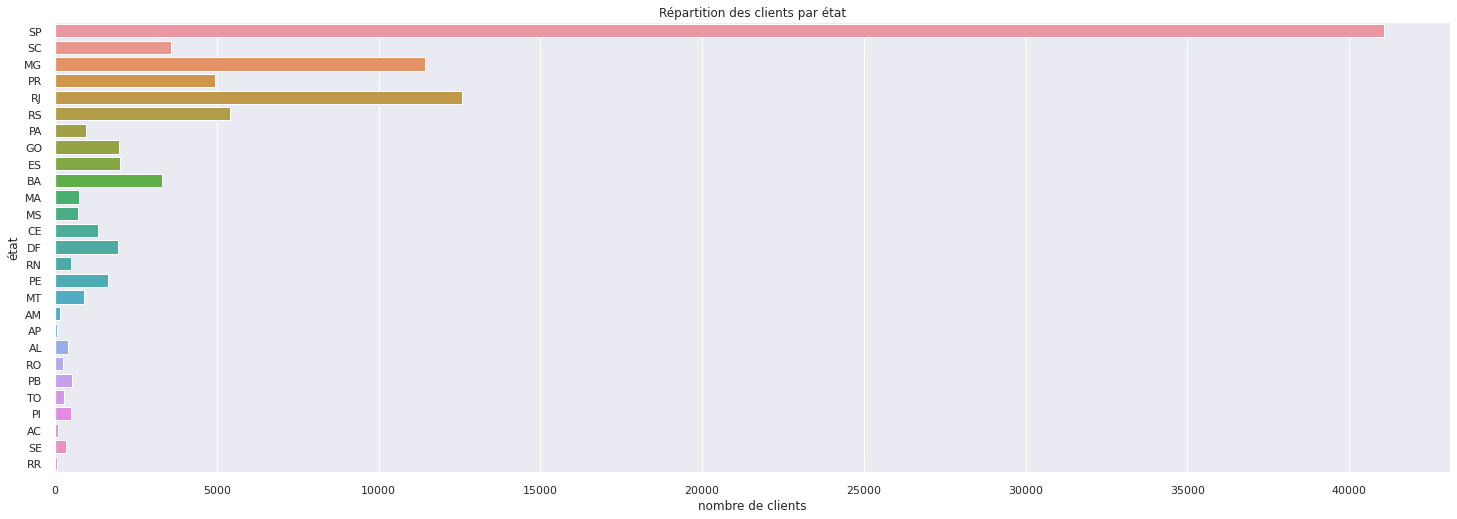

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

sns.set(rc={'figure.figsize':(25, 8.27)}, style = "darkgrid")
s1 = sns.countplot(y='state', data = unique_df)
s1.set(title="Répartition des clients par état", xlabel="nombre de clients", ylabel="état")

La majorité des clients sont situés au sud du Brésil, plus précisément dans les états de Sao Paulo, Rio de Janeiro et Minas Gerais.

### Répartition des clients par note moyenne

Ici, on répartit les clients dans plusieurs catégories selon les évaluations qu'ils donnent en moyenne après leurs commandes.

[Text(0.5, 1.0, 'Répartition des clients par évaluations moyennes'),
 Text(0.5, 0, 'nombre de clients'),
 Text(0, 0.5, 'évaluation moyenne')]

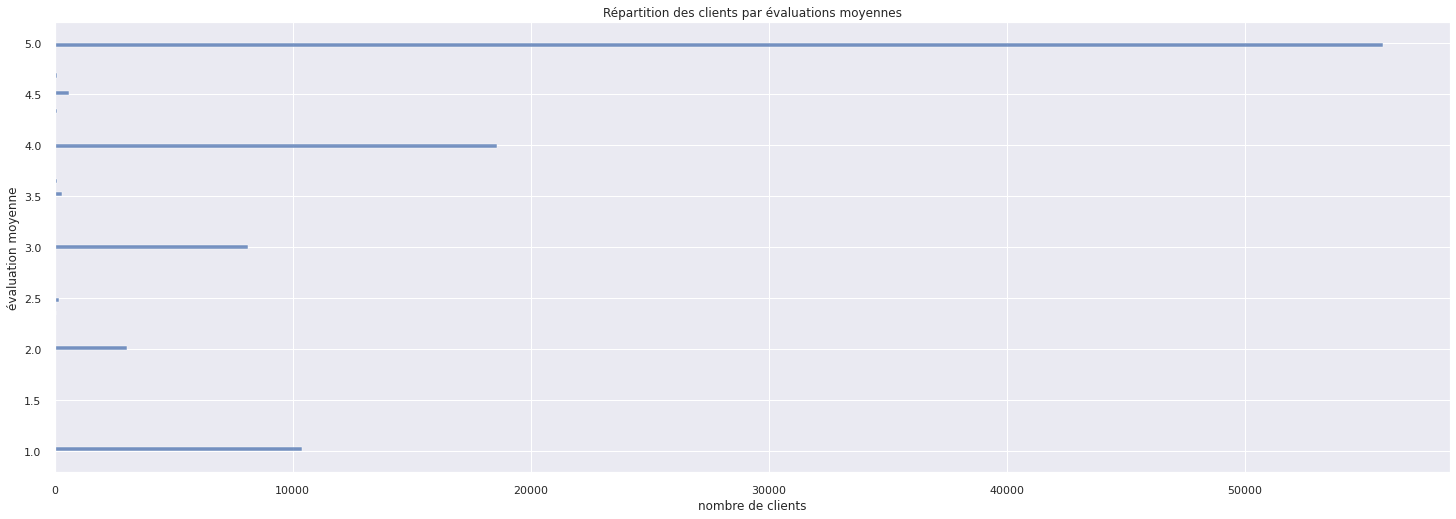

In [26]:
sns.histplot(data=unique_df, y="avg_review").set(title="Répartition des clients par évaluations moyennes", xlabel="nombre de clients", ylabel="évaluation moyenne")

On remarque nettement que les clients ont tendance à être polarisés dans leurs évaluations : la majeure partie d'entre eux a tendance à donner une note proche du maximum, et une grosse proportion d'entre eux laisse aussi des notes très faibles. On constate en revanche que le nombre de clients qui laissent des notes moyennes (2, 3) n'est pas très élevé.

### Répartition des clients par total dépensé

count    97567.000000
mean       147.107989
std        223.372235
min          0.850000
25%         48.900000
50%         89.900000
75%        159.900000
max      13440.000000
Name: total_spent, dtype: float64

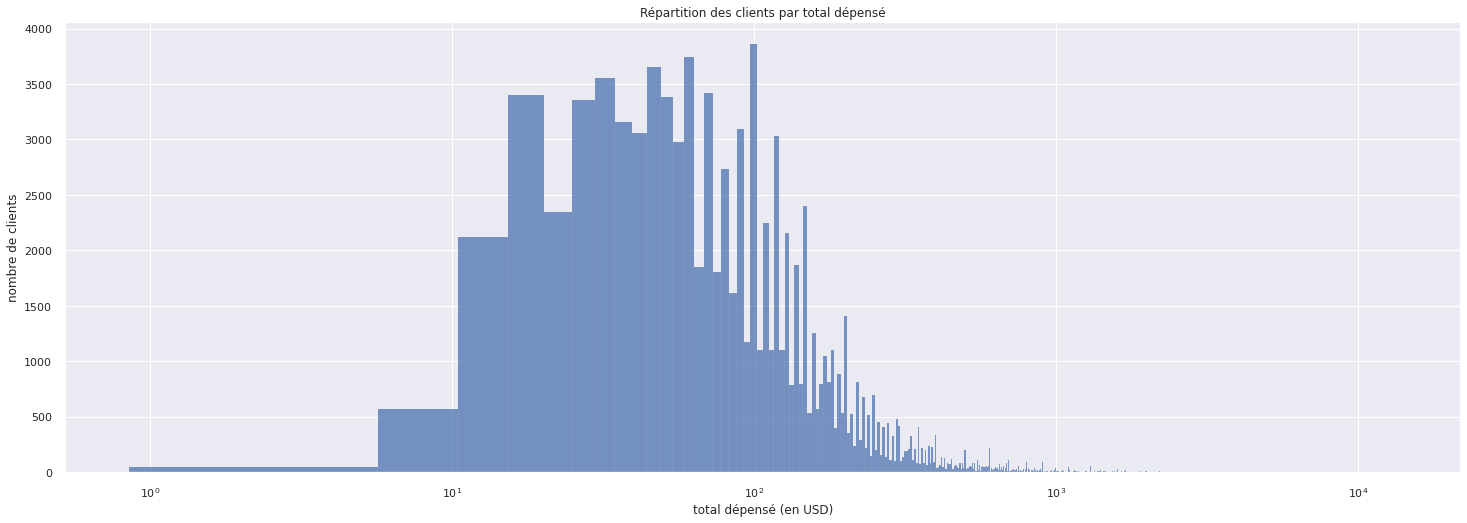

In [27]:
sns.histplot(data=unique_df, x="total_spent").set(xscale="log", title="Répartition des clients par total dépensé", xlabel="total dépensé (en USD)", ylabel="nombre de clients")
unique_df["total_spent"].describe()

On remarque que la grande majorité des clients a dépensé entre 10 et 100 euros au total. Cependant, on pourra aussi noter que quelques outliers ont dépensé des sommes très importantes au total. Ainsi, le client ayant dépensé le plus a payé au total 13440 dollars (c'est d'ailleurs ce qui justifie le choix d'une échelle logarithmique pour ce graphique).

### Répartition des clients par dépenses moyennes

Nous pouvons aussi nous intéresser à la taille des paniers moyens de nos clients :

Informations statistiques pour les montants moyens des paniers :
count    97567.000000
mean       137.874295
std        209.203915
min          0.850000
25%         46.950000
50%         87.798000
75%        149.900000
max      13440.000000
Name: avg_spent, dtype: float64


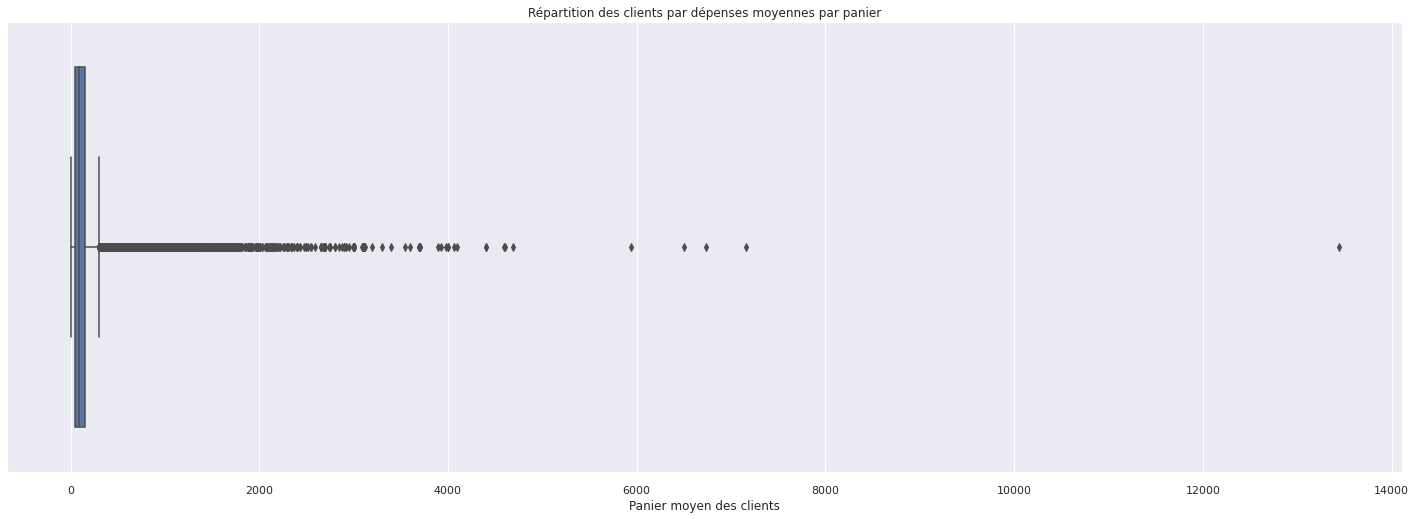

In [28]:
sns.boxplot(x=unique_df["avg_spent"]).set(title="Répartition des clients par dépenses moyennes par panier",
                                         xlabel="Panier moyen des clients")
print("Informations statistiques pour les montants moyens des paniers :")
print(unique_df["avg_spent"].describe())

On constate ici la présence de quelques valeurs aberrantes, dont un client qui a commandé en moyenne pour 13440 dollars (!) à chaque commande. Ces valeurs extrêmes affectent en revanche la lisibilité de notre graphe, changeons donc d'échelle pour utiliser une échelle logarithmique :

[None,
 Text(0.5, 1.0, 'Répartition des clients par dépenses moyennes par panier'),
 Text(0.5, 0, 'Panier moyen des clients')]

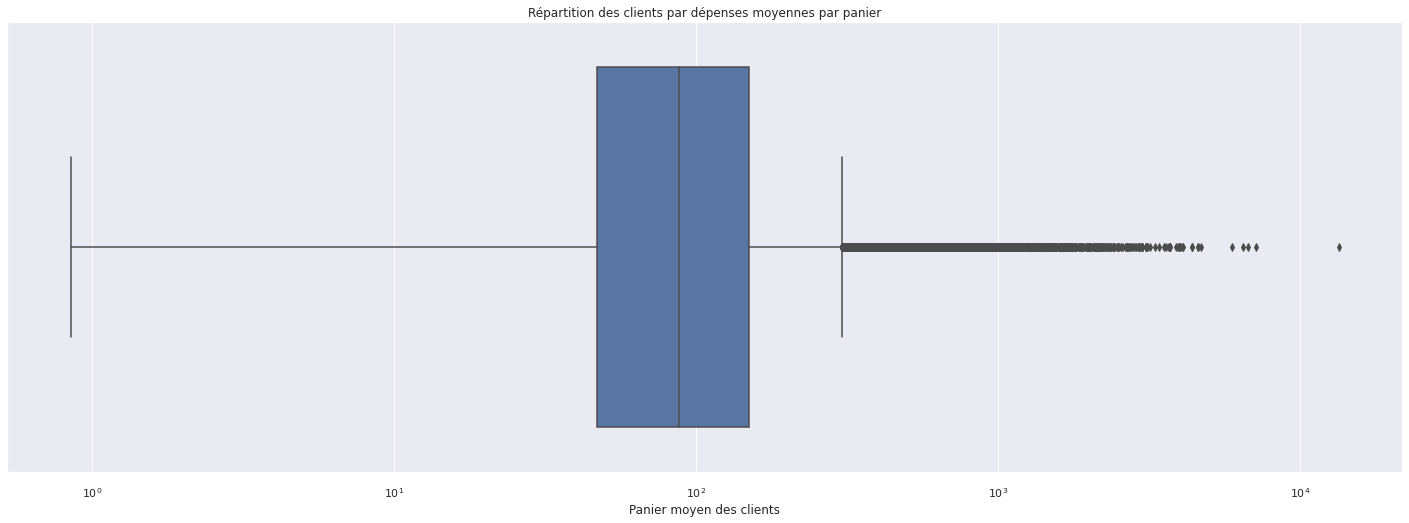

In [29]:
sns.boxplot(x=unique_df["avg_spent"]).set(xscale="log",
                                         title="Répartition des clients par dépenses moyennes par panier",
                                         xlabel="Panier moyen des clients")

On peut tirer plusieurs informations de ces analyses :
- La moitié des clients commande des paniers entre 50 et 150 dollars environ, avec un panier médian à 88 dollars
- Un petit nombre de clients passe des commandes pour des montants très élevés pouvant aller jusqu'à 13440 $. Ces valeurs aberrantes tirent la moyenne vers le haut, ce qui nous 

### Répartition des clients par nombre de paiements moyen

[Text(0.5, 1.0, 'Nombre de paiements moyen par client'),
 Text(0.5, 0, 'nombre de paiements'),
 Text(0, 0.5, 'nombre de clients')]

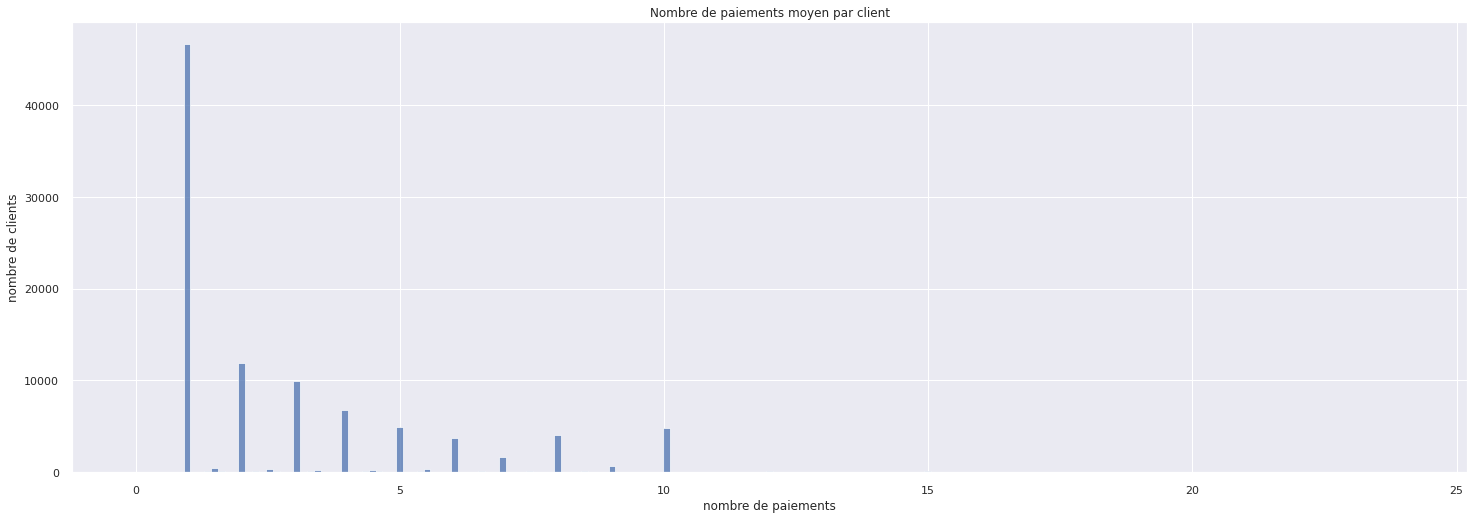

In [30]:
sns.histplot(data=unique_df, x="avg_installments").set(title="Nombre de paiements moyen par client", xlabel="nombre de paiements", ylabel="nombre de clients")

On remarque que la grande majorité des clients effectue un seul paiement. Cependant, on constate aussi que l'échelle du graphique monte jusqu'à 25 dans les abscisses : cela veut dire qu'il y a certaines valeurs aberrantes qui n'apparaissent pas dans ce graphique. Pour les mettre en évidence, dessinons un boxplot :

[Text(0.5, 1.0, 'Nombre de paiements moyen par client'),
 Text(0.5, 0, 'nombre de paiements')]

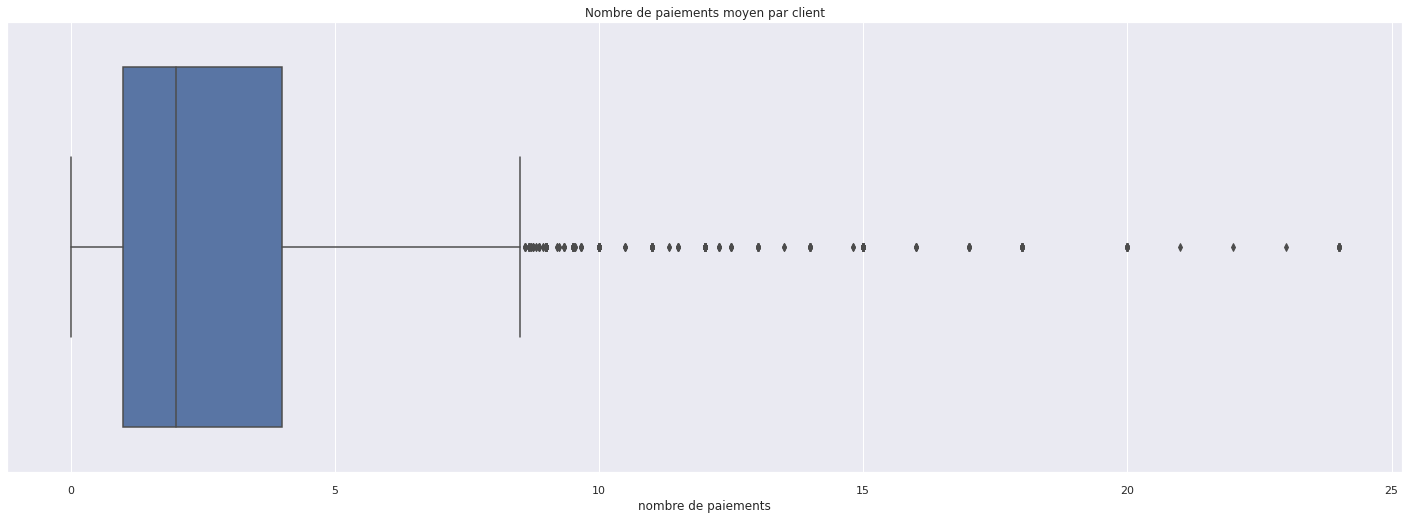

In [31]:
sns.boxplot(data=unique_df, x="avg_installments").set(title="Nombre de paiements moyen par client", xlabel="nombre de paiements")

Plusieurs remarques :
- certains clients ont réalisé 0 paiements : il serait judicieux d'aller vérifier dans les données si c'est du à une erreur ou non. Après vérification, on constate que certains clients n'ont pas encore réalisé le premier paiement de leur commande, mais que toutes les données sont cohérentes par ailleurs. On pourra donc supposer qu'il s'agit de clients ayant acheté à crédit, ou qui en tout cas paieront leur commande plus tard.
- là encore, nous avons des outliers: un ou plusieurs clients ont notamment réalisé 24 paiements sur une seule commande.

### Répartition des clients par distance moyenne avec le vendeur

[Text(0.5, 1.0, 'Distance moyenne entre chaque client et son vendeur'),
 Text(0.5, 0, 'distance'),
 Text(0, 0.5, 'nombre de clients')]

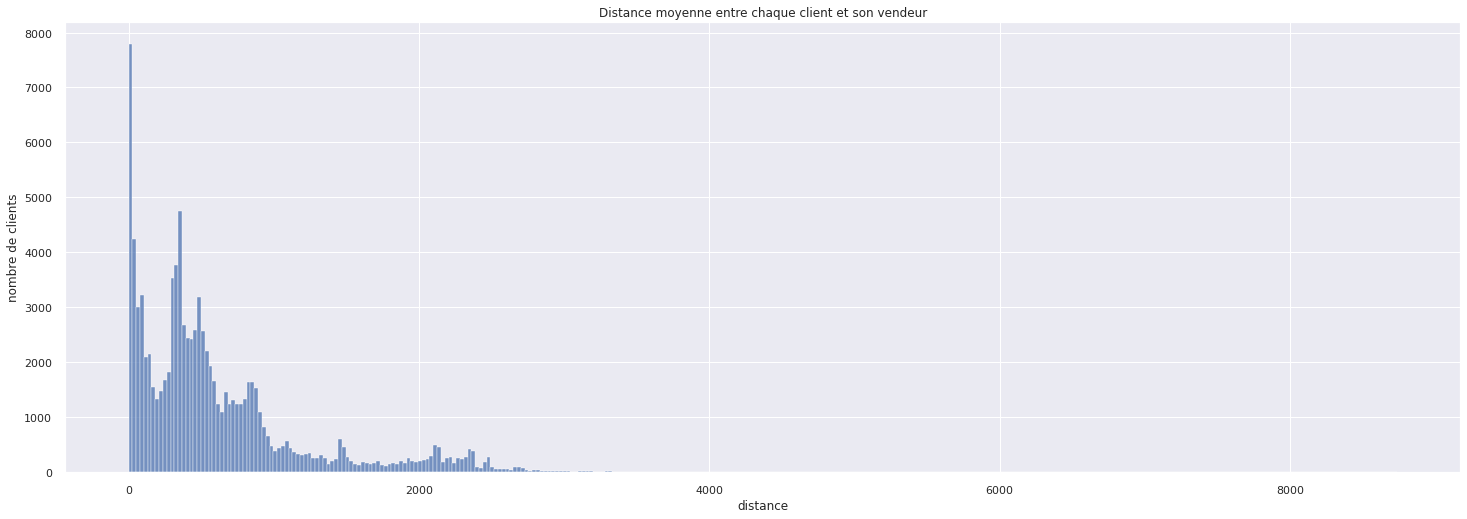

In [32]:
sns.histplot(data=unique_df, x="distance_to_seller").set(title="Distance moyenne entre chaque client et son vendeur", xlabel="distance", ylabel="nombre de clients")

On constate que beaucoup de clients habitent très près de leurs vendeurs. Cependant, il y a aussi des valeurs aberrantes qui agrandissent l'échelle horizontale et nous empêchent de bien visualiser les données.

[Text(0.5, 1.0, 'Distance moyenne entre chaque client et son vendeur'),
 Text(0.5, 0, 'distance')]

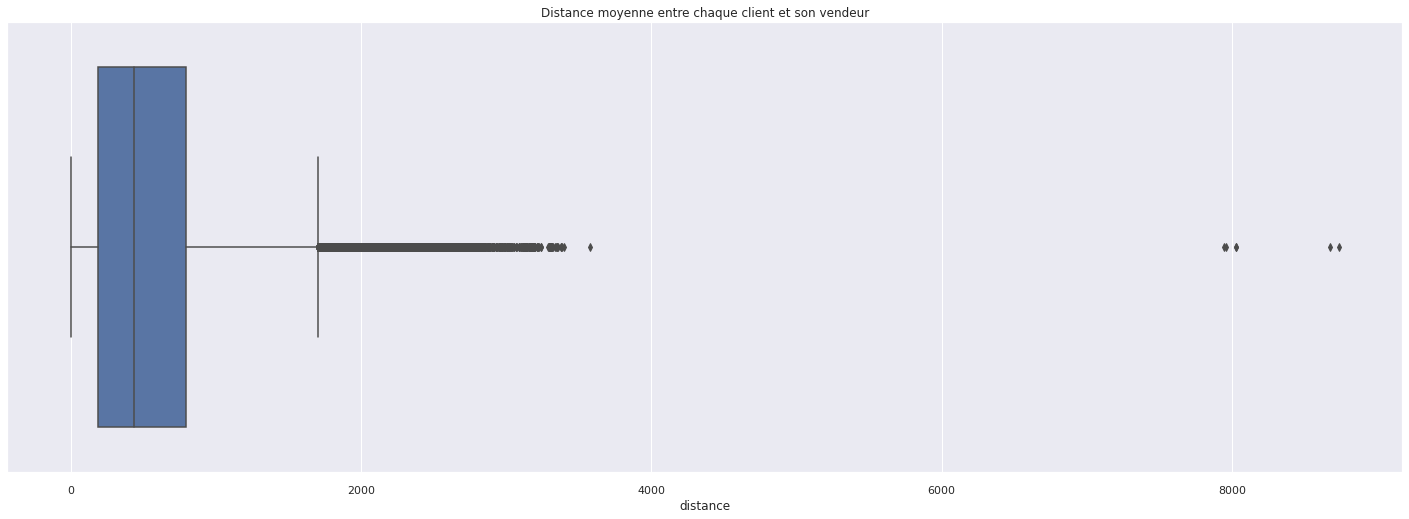

In [33]:
sns.boxplot(data=unique_df, x="distance_to_seller").set(title="Distance moyenne entre chaque client et son vendeur", xlabel="distance")

[None,
 Text(0.5, 1.0, 'Distance moyenne entre chaque client et ses vendeurs'),
 Text(0.5, 0, 'distance'),
 Text(0, 0.5, 'nombre de clients')]

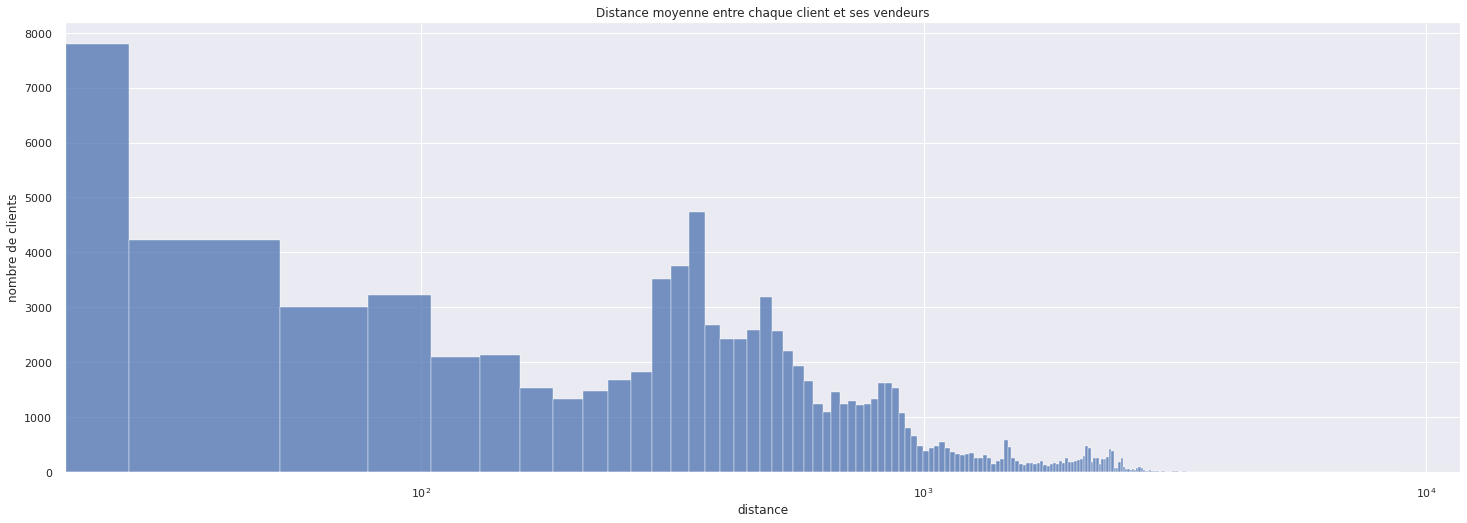

In [34]:
sns.histplot(data=unique_df, x="distance_to_seller").set(xscale="log", title="Distance moyenne entre chaque client et ses vendeurs", xlabel="distance", ylabel="nombre de clients")

Ici, on constate deux choses :
- La plupart des clients habitent près de leurs vendeurs (à 100 km au maximum)
- On observe un pic aux alentours de 600 km
- Quelques rares clients habitent à 8000 km du vendeur environ. On pourra supposer que ces clients sont basés à l'étranger.

## Nouvelles informations du client et modification des données à utiliser

Après cette étape de visualisation des données, Yannick, notre correspondant chez Olist, nous contacte pour nous donner de nouvelles instructions. Il souhaiterait que nous basions notre clustering sur une analyse de type RFM (Recency, Frequency, Monetary analysis). Il s'ensuit que certaines données que nous avons collectées ne seront pas forcément utilisées, mais aussi que nous devons également collecter des données concernant la date de la dernière commande des clients ainsi que la fréquence à laquelle ils commandent. Or, ces données ne sont pas présentes dans la dataframe unique_df. Nous allons donc devoir les y ajouter. Notre dataframe devra contenir ces deux colonnes supplémentaires :
- last_order, qui contiendra le nombre de jours passés depuis la dernière commande
- orders_frequency, qui contiendra le nombre de commandes passées par an par le client.

### Ajout de last_order

Pour ajouter ces colonnes, il nous faut repartir de nos données de base. Ici, nous allons nous baser sur orders_df.

In [66]:
unique_df = pickle.load(open("clean_data.pkl", "rb"))
orders_info_df = orders_df.merge(customers_df[["customer_id", "customer_unique_id"]], how="left", on="customer_id")
orders_info_df["order_purchase_timestamp"] = pd.to_datetime(orders_info_df["order_purchase_timestamp"])

last_orders = orders_info_df[["customer_unique_id", "order_purchase_timestamp"]].groupby(["customer_unique_id"]).max()
current_time = pd.Timestamp(year=2020, month=12, day=31, hour=0, minute=0, second=0)
last_orders = last_orders["order_purchase_timestamp"].apply(lambda date: (current_time - date).days)
last_orders.rename("last_order", inplace=True)
unique_df = unique_df.merge(last_orders, how="left", left_on="unique_id", right_index=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97567 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           97567 non-null  object 
 1   zip                 97567 non-null  int64  
 2   city                97567 non-null  object 
 3   state               97567 non-null  object 
 4   lat                 97567 non-null  float64
 5   lng                 97567 non-null  float64
 6   avg_review          97567 non-null  float64
 7   total_spent         97567 non-null  float64
 8   avg_spent           97567 non-null  float64
 9   avg_installments    97567 non-null  float64
 10  distance_to_seller  97567 non-null  float64
 11  last_order_x        97567 non-null  int64  
 12  orders_frequency    97567 non-null  int64  
 13  last_order_y        97567 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 11.2+ MB
None


### Ajout de orders_frequency

In [36]:
orders_count = orders_info_df[["customer_unique_id", "order_purchase_timestamp"]].groupby(["customer_unique_id"]).count()

orders_count.rename(columns={"order_purchase_timestamp": "orders_frequency"}, inplace=True)
unique_df = unique_df.merge(right=orders_count, how="left", left_on="unique_id", right_index=True)
print(unique_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97567 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           97567 non-null  object 
 1   zip                 97567 non-null  int64  
 2   city                97567 non-null  object 
 3   state               97567 non-null  object 
 4   lat                 97567 non-null  float64
 5   lng                 97567 non-null  float64
 6   avg_review          97567 non-null  float64
 7   total_spent         97567 non-null  float64
 8   avg_spent           97567 non-null  float64
 9   avg_installments    97567 non-null  float64
 10  distance_to_seller  97567 non-null  float64
 11  last_order          97567 non-null  int64  
 12  orders_frequency    97567 non-null  int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 10.4+ MB
None


### Fréquence de commande des clients

<AxesSubplot:xlabel='orders_frequency'>

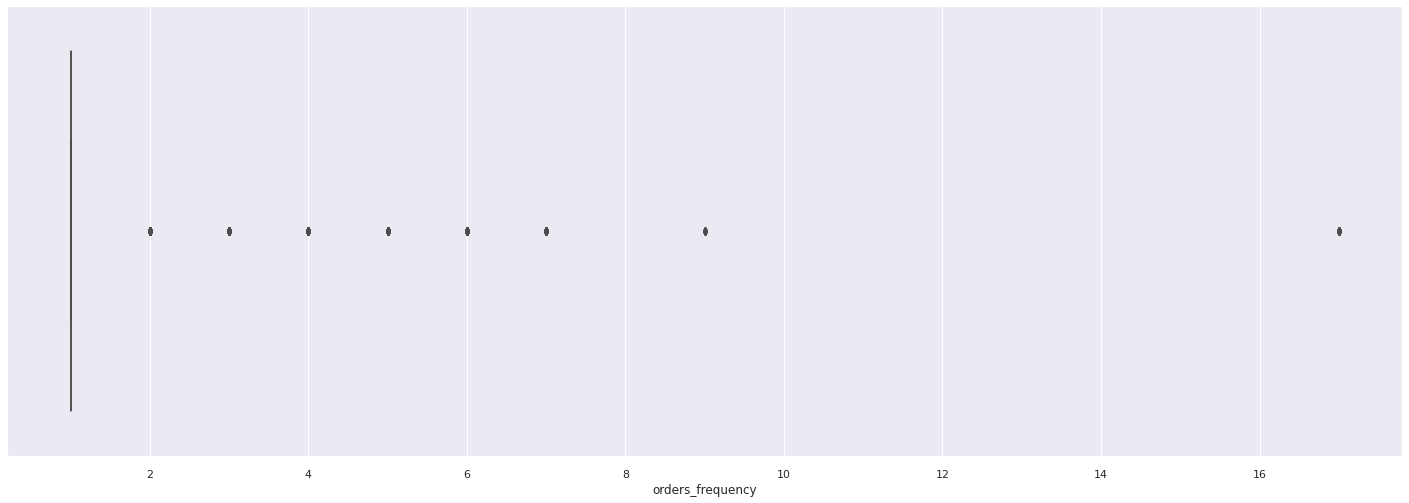

In [37]:
sns.boxplot(data=unique_df, x="orders_frequency")

En observant ce graphique et nos données, on s'aperçoit que la plupart des clients ont en fait réalisé une seule commande, à quelques rares exceptions près.

Enfin, on enregistre à nouveau la dataframe unique_df :

In [38]:
pickle.dump(unique_df, open("clean_data.pkl", "wb"))

## Clustering

Dans cette section, nous allons réaliser un modèle de clustering qui réalisera une segmentation des clients basée sur la méthode RFM (Récence, Fréquence, Montant). Cette segmentation sépare les clients selon trois critères : la date de la dernière commande passée, le nombre de commandes passées et le montant total dépensé par le client. 

### Choix des variables et analyses

Commençons par charger notre dataframe. Les colonnes qui vont nous être utiles ici sont les colonnes total_spent, last_order et order_frequency.

In [67]:
df = pickle.load(open("clean_data.pkl", "rb"))
cluster_df = df[["total_spent", "last_order", "orders_frequency"]]
print(cluster_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97567 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_spent       97567 non-null  float64
 1   last_order        97567 non-null  int64  
 2   orders_frequency  97567 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.0 MB
None


D'abord, affichons une heatmap qui représente la matrice de corrélation de la dataframe afin de voir si certaines colonnes sont corrélées :

<AxesSubplot:>

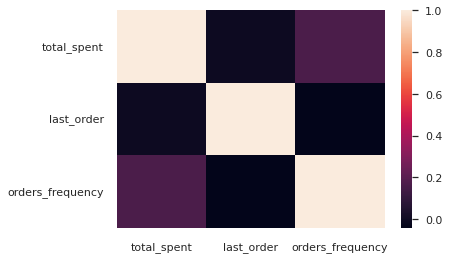

In [68]:
sns.heatmap(cluster_df.corr())

On constate que les corrélations entre nos différentes features sont faibles, voire nulles.

Avant de réaliser un clustering sur nos données, il est important de mieux les comprendre. Pour cela, nous allons réaliser un nuage de points en trois dimensions de notre dataframe en utilisant la technique du PCA (Principal Component Analysis). Cela nous permettra de mieux identifier les différents clusters potentiels dans nos données.

Pour bien voir l'intérêt du PCA, affichons d'abord nos données sans PCA :

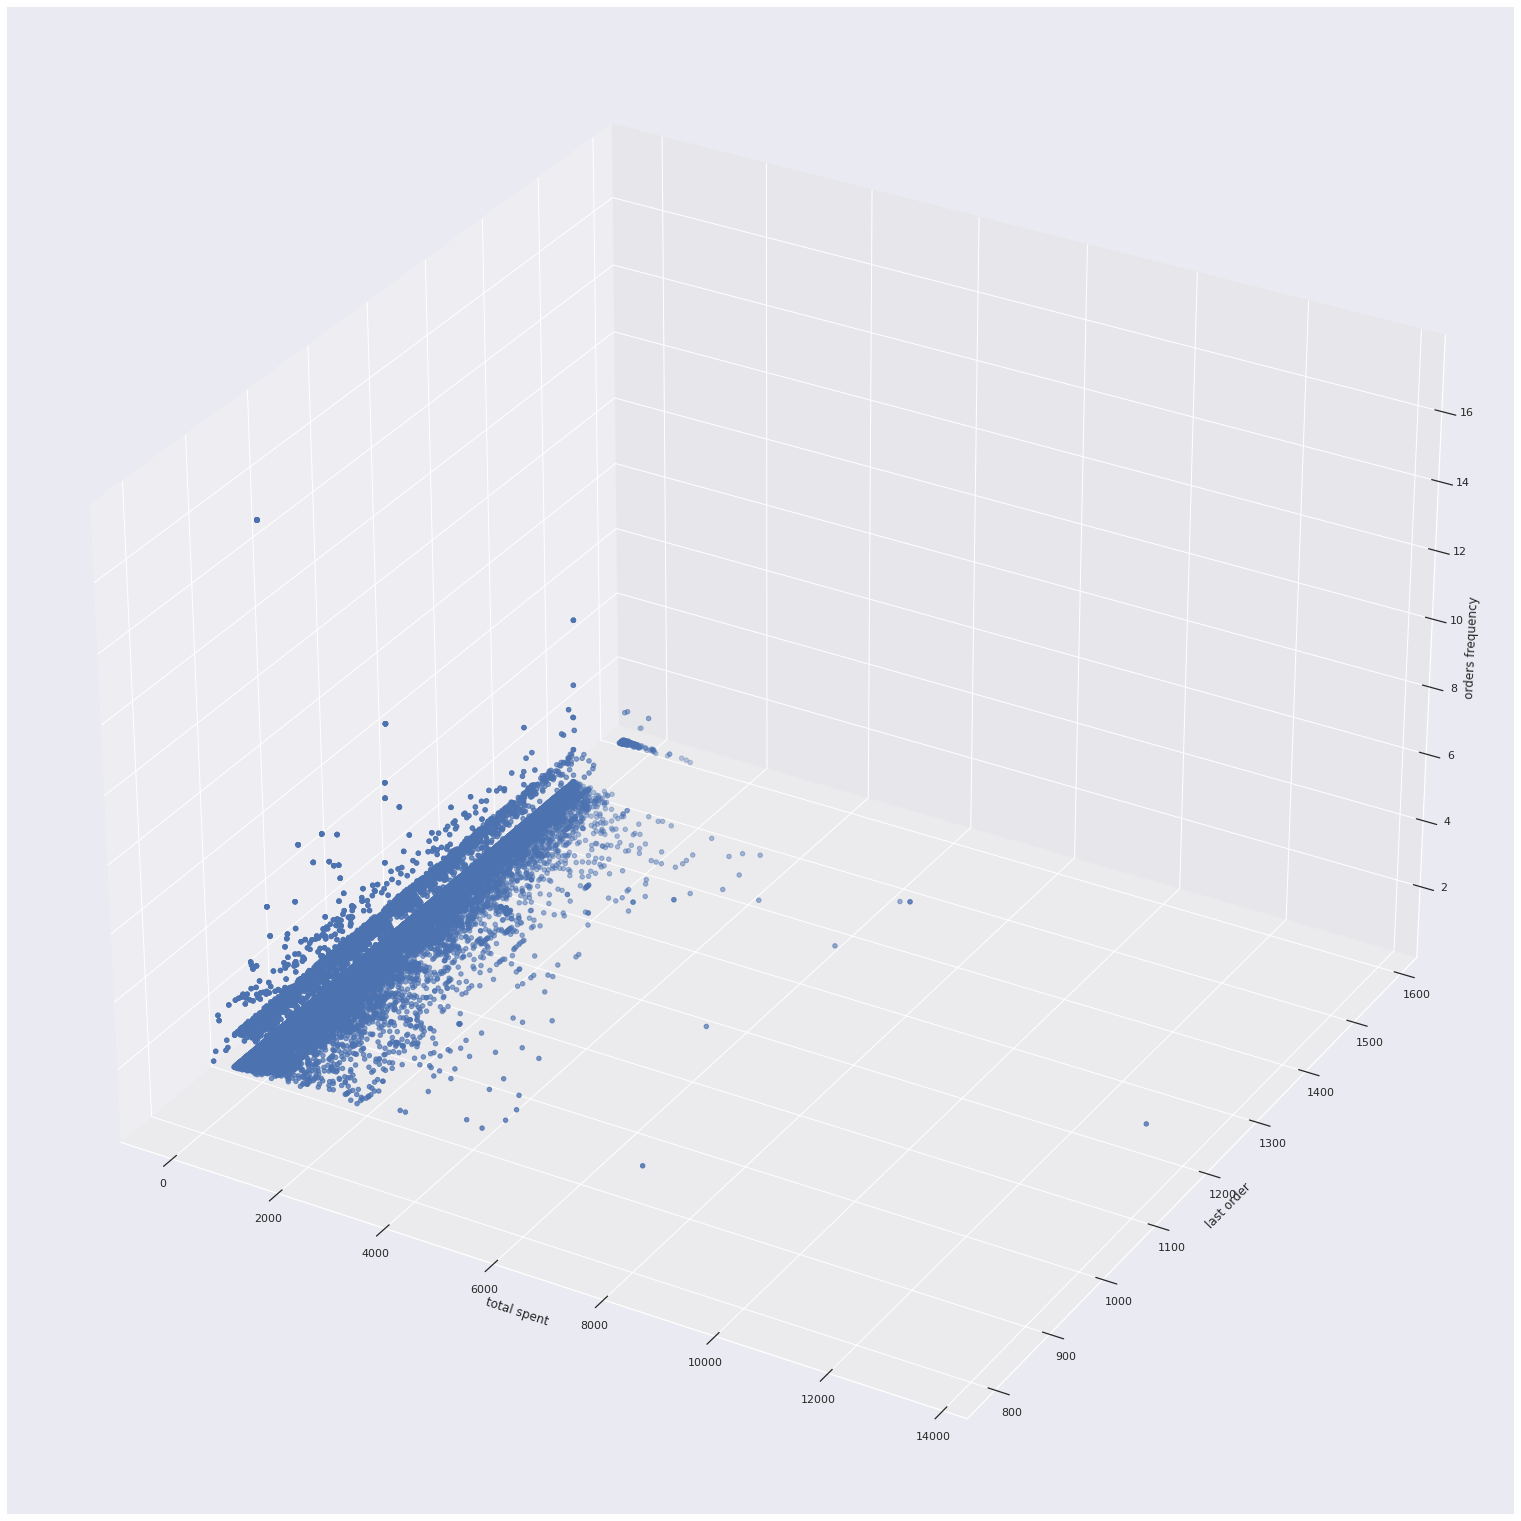

In [69]:
# Affichage du nuage de points sans PCA
fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['total_spent']
y = cluster_df['last_order']
z = cluster_df['orders_frequency']

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z)

plt.show()

Et, maintenant, faisons la même chose en appliquant le PCA à nos données avant de les afficher :

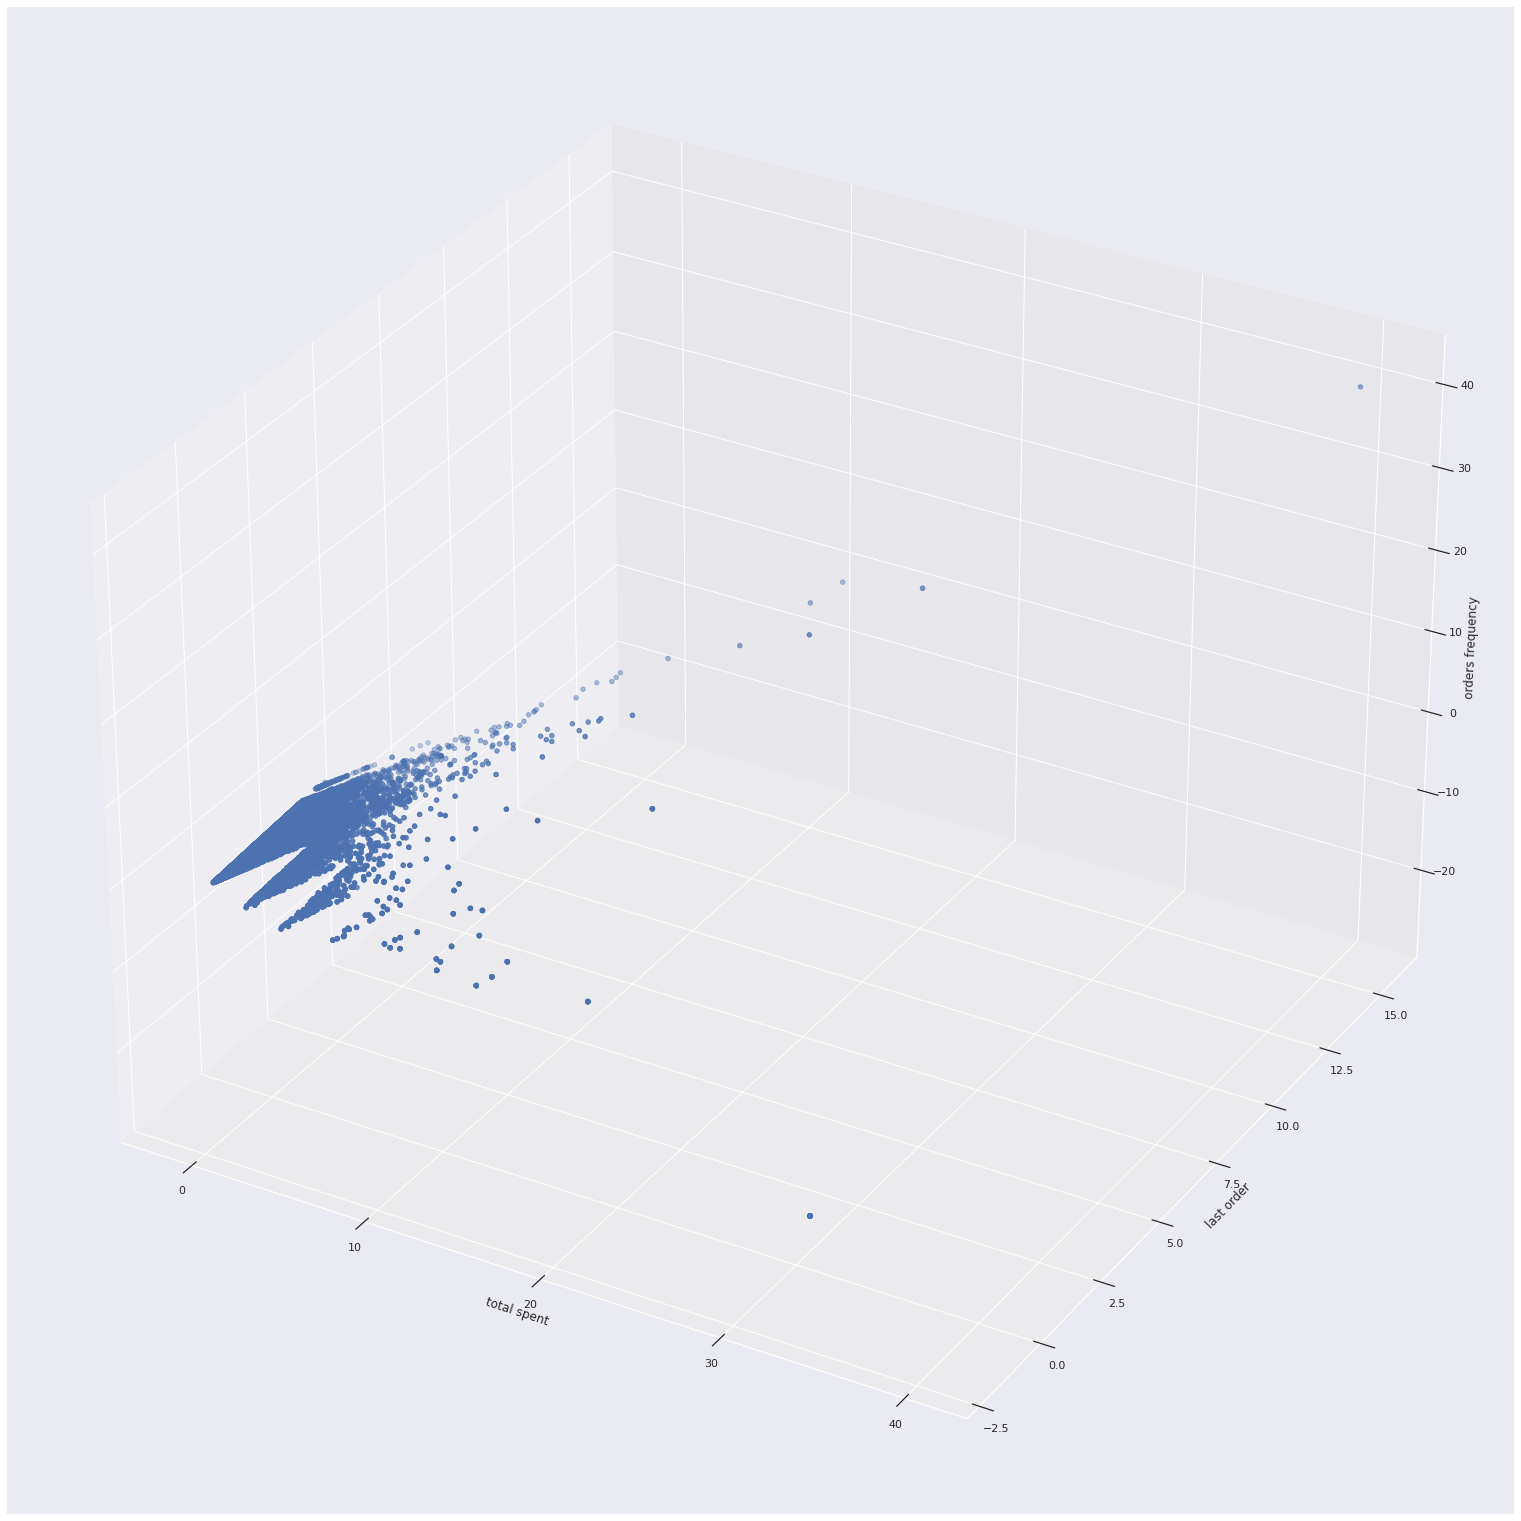

In [70]:
# Affichage du nuage de points avec PCA
pca = PCA(n_components=3)
standardized_cluster_df = StandardScaler().fit_transform(cluster_df)
pca_cluster = pd.DataFrame(pca.fit_transform(standardized_cluster_df))

fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = pca_cluster[0]
y = pca_cluster[1]
z = pca_cluster[2]

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z)

plt.show()


Bien qu'aucun de ces deux nuages de points en 3D ne soit très lisible, on peut tout de même plus facilement distinguer des groupes de points dans le second graphique (après PCA).

Si l'on affiche maintenant la heatmap de nos données après y avoir appliqué le PCA, on constate qu'il n'y a plus de corrélation entre les différentes features. L'avantage du PCA est également d'éliminer ces colinéarités entre features, qui peuvent affecter la précision de notre modèle de clustering :

<AxesSubplot:>

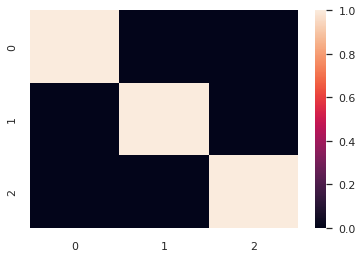

In [71]:
sns.heatmap(pca_cluster.corr())

### Clustering

#### K-means

Avant de commencer à créer nos modèles de clustering, une question se pose : combien de clusters faut-il identifier ? En effet, lorsque l'on crée un modèle, il faut lui donner le nombre de clusters à créer. Pour cela, nous pouvons utiliser la méthode elbow, qui identifie le nombre optimal de clusters. Au-delà de ce nombre, on court le risque de créer trop de clusters, qui seront trop restreints individuellement.

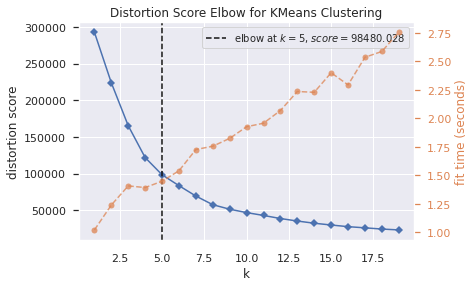

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(pca_cluster)       
visualizer.show()        

La librairie Yellowbrick, que nous avons utilisée pour générer ce graphique, nous montre le nombre de clusters optimal, 5 dans ce cas. Maintenant que nous connaissons le nombre de clusters à utiliser, nous pouvons générer notre modèle de clustering à l'aide de la méthode des k-means :

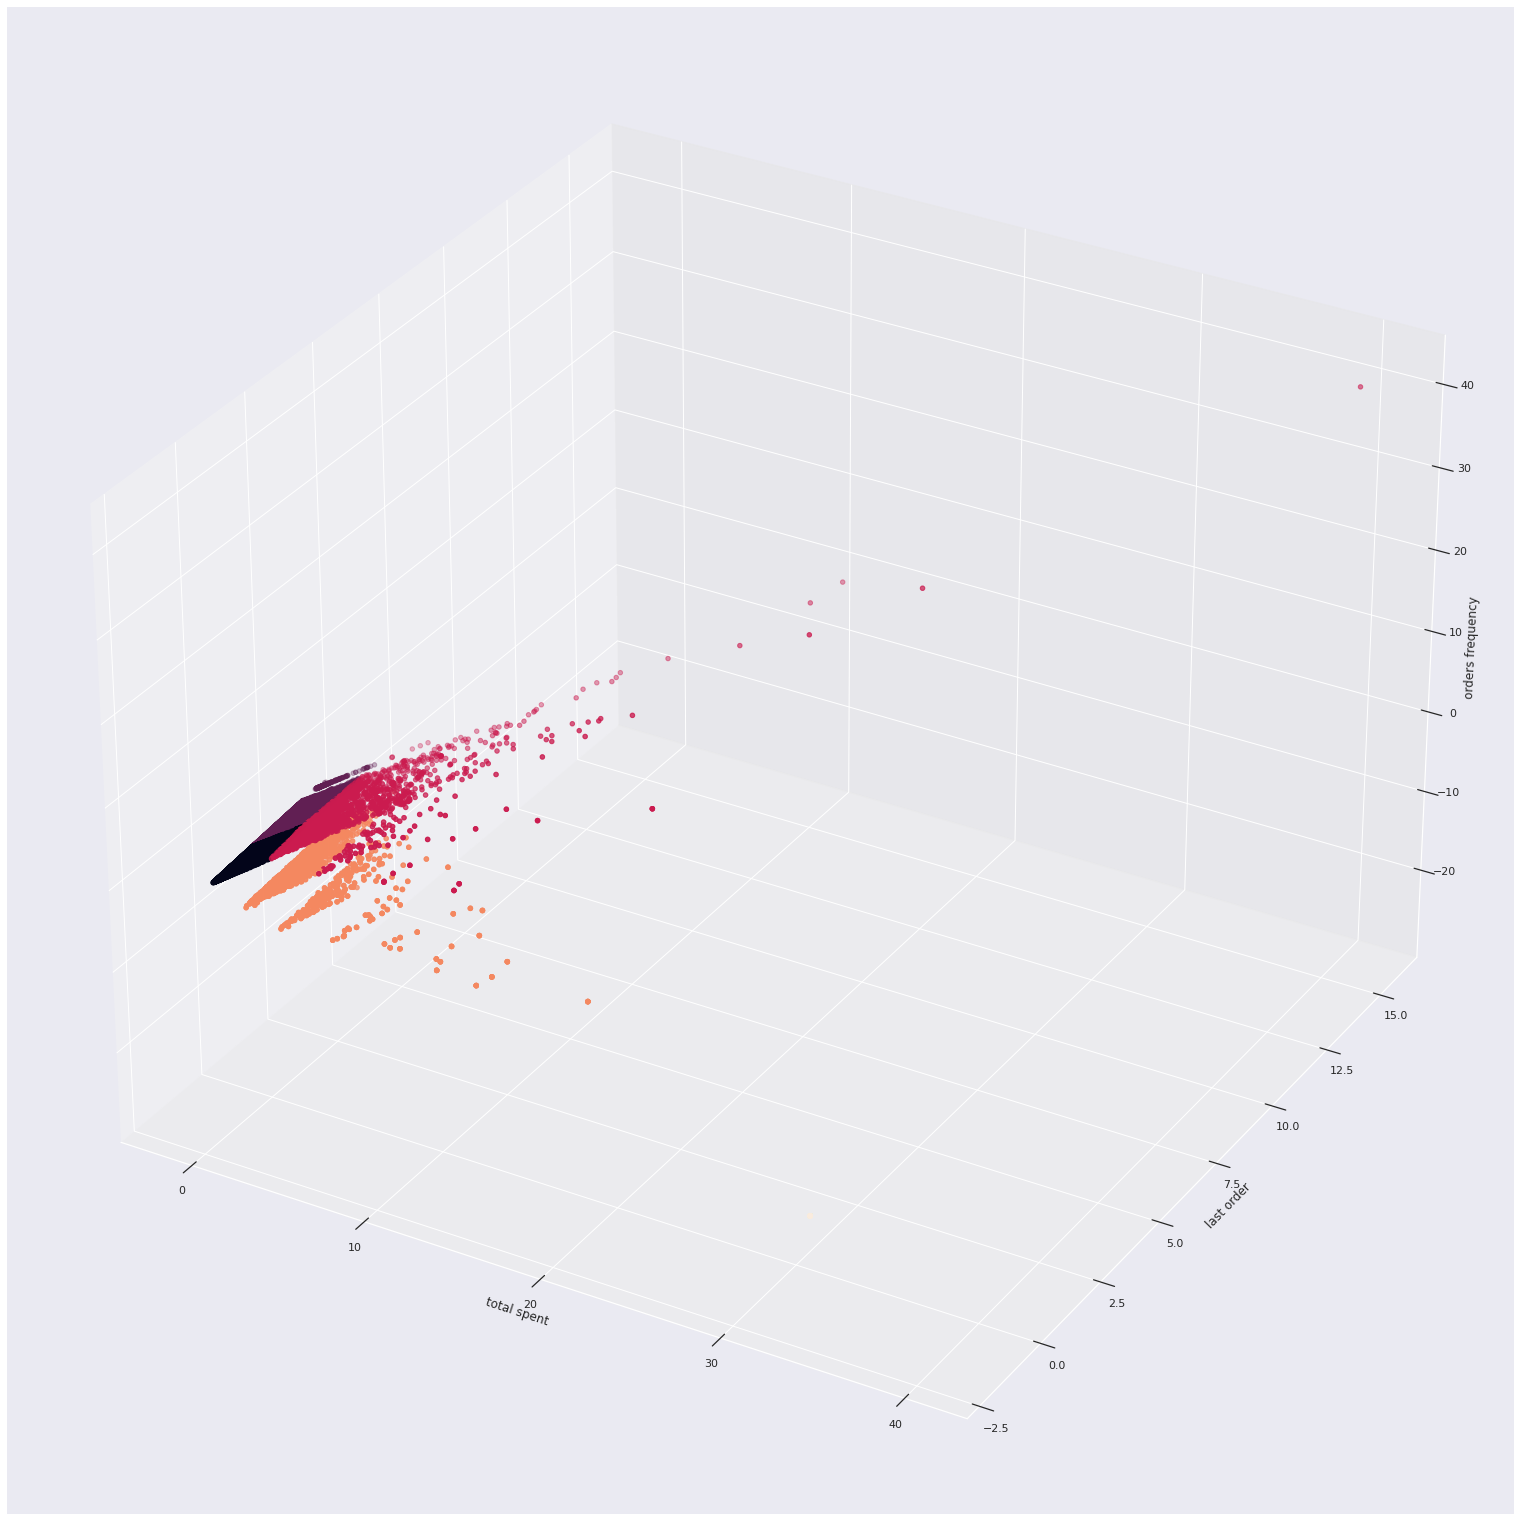

In [73]:
clusters = KMeans(n_clusters=5).fit(pca_cluster.astype(float))


fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = pca_cluster[0]
y = pca_cluster[1]
z = pca_cluster[2]

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z, c=clusters.labels_.astype(float))

plt.show()


Le nuage de points 3D obtenu n'est pas très lisible. Un bon moyen de mieux visualiser les différences entre chaque cluster obtenu est de dessiner un graphique en toile d'araignée où chaque axe correspond à une feature :

         total_spent   last_order  orders_frequency
cluster                                            
0         114.332141   982.363153          1.000000
1         115.405073  1242.693851          1.000000
2        1191.726634  1088.456992          1.114689
3         230.721917  1072.750785          2.202446
4         729.620000   863.000000         17.000000
   cluster  total_spent  last_order  orders_frequency
0        0    -0.764252   -0.481239         -0.492915
1        1    -0.761987    1.375060         -0.492915
2        2     1.510154    0.275268         -0.476592
3        3    -0.518550    0.163274         -0.321783
4        4     0.534636   -1.332362          1.784205


/home/vincent/.local/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/vincent/.local/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/vincent/.local/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/vincent/.local/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/vincent/.local/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be

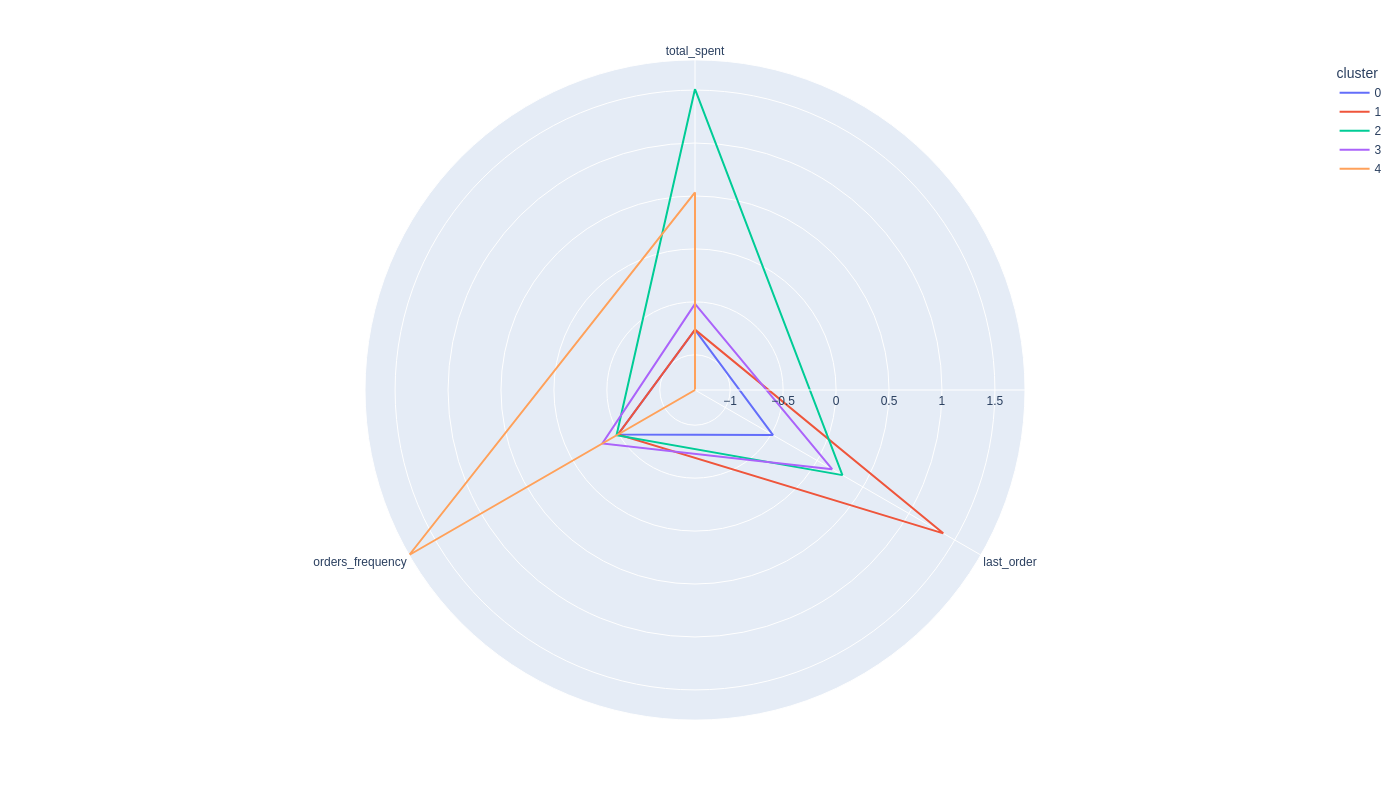

In [86]:
k_means_cluster_df = pd.DataFrame(cluster_df)
k_means_cluster_df["cluster"] = clusters.labels_.astype(int)
# On calcule la moyenne de chaque feature à l'intérieur de chaque catégorie
categories_df = k_means_cluster_df.groupby(["cluster"]).mean()
print(categories_df)
# On normalise ensuite toutes les valeurs de la dataframe pour avoir une
# échelle cohérente dans notre graphique
categories_df = (categories_df-categories_df.mean())/categories_df.std()
categories_df.reset_index(inplace=True)
print(categories_df)
melted_df = pd.melt(categories_df, id_vars=['cluster'], var_name='feature', value_name='data',
             value_vars=['total_spent', 'last_order', 'orders_frequency'])

fig = px.line_polar(melted_df, r="data", theta="feature", color="cluster", line_close=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()



Les tableaux et le graphique ci-dessus nous permettent de mettre en évidence plusieurs éléments : 
- les clients qui font partie du groupe 2 dépensent nettement plus d'argent que les autres groupes (environ 1200 dollars au total par client en moyenne). Une attention toute particulière devrait donc être prêtée aux clients assignés à ce groupe par le modèle
- Les clients du groupe 4 présentent aussi un intérêt. Ils passent commande beaucoup plus fréquemment que les autres clients et dépensent aussi beaucoup globalement (730 dollars en moyenne)
- Les clients des groupes 0, 1 et 3 ne présentent qu'un intérêt limité dans la mesure où ils dépensent relativement peu comparé aux autres.

In [90]:
# Performances du modèle :
labels = clusters.labels_
metrics.silhouette_score(pca_cluster, labels)

KeyboardInterrupt: 

In [ ]:
Classification ascendante hiérarchique (CAH)  (à venir)

In [ ]:
Dbscan (à venir)

In [ ]:
Optics (à venir)